# Optimization

### Collect training features

In [11]:
import numpy as np
import random
import os, sys
import warnings

from matplotlib import pyplot as plt

from env_variables import *
from lib.esn import ESN
from dataset.loading import DataLoader

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

data_path = '../../../'
dl = DataLoader(data_path)

dr = []
speakers = []
XorZ = "Z"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ,
    "N":100
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features_train, labels_train, _ = dl.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


### Regroup data and subset phonemes

In [12]:
from dataset.data_processing import *

phonemes, features_train, labels_train = filter_data(features_train, labels_train, limit=200)

Filtered to 7800 samples of shape (10, 14)


### Classification

In [13]:
from experiments.helpers.experiment_helpers import *
from sklearn.base import BaseEstimator, ClassifierMixin

class Classifier(BaseEstimator, ClassifierMixin):

    def __init__(self,
                 W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights):
        self.W_in_scale = W_in_scale
        self.spectral_radius = spectral_radius
        self.b_scale = b_scale
        self.weights = weights

        self.n_mels = None
        self.XorZ = None
        self.N = None
        self.n_samples = None
        self.classes = None
        self.esn = None
        self.Cs_clas = None
        self.Ns_clas = None

    def fit(self, X, y, **params):
        self.n_mels = params["n_mels"]
        self.XorZ = params["XorZ"]
        self.N = params["N"]

        # Group data by class
        group = group_by_labels(X, y)

        self.classes = list(group.keys())
        self.n_samples = sum([len(x) for x in list(group.values())])

        print(f"Number of samples: {self.n_samples}")
        # Init Reservoir
        esn_params = {
            "in_dim": self.n_mels,
            "out_dim": self.n_mels,
            "N": self.N,
            "W_in_scale": self.W_in_scale,
            "b_scale": self.b_scale,
            "spectral_radius": self.spectral_radius,
            "weights": self.weights
        }
        self.esn = ESN(esn_params)
        self.Cs_clas, self.Ns_clas = compute_Cs_and_Ns(group=group, esn=self.esn, aperture="auto", normalize=True, XorZ=self.XorZ, cache=False)

        # Return the classifier
        return self

    def predict(self, X):
        y = []
        for sample in X:
            x = self.esn.run(sample.T, XorZ=self.XorZ)
            es = evidences_for_Cs(x,self.Cs_clas,self.Ns_clas)
            if self.XorZ == "X":
                es = [ np.sum(p) for p in es ]
            y.append(self.classes[np.argmax(es)])

        return y

#### Training

In [14]:
clas = Classifier(1.5,
    .2,
    1.5,
    .1)

clas.fit(features_train, labels_train, **{
    "n_mels": n_mels,
    "XorZ": "X",
    "N": 100
})

Number of samples: 7800
- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  228.64965623213567
normalizing
Target:  49.89289826279734
std 1.569091829560916
- computing negative conceptors


Classifier(W_in_scale=1.5, b_scale=0.2, spectral_radius=1.5, weights=0.1)

#### Testing

In [15]:
print("Testing...")

features_test, labels_test, _ = dl.collectFeaturesInSegments(
    ft='Test',n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=[],dr=dr,sentence=[],
    subsamples=subsamples,path_option=path_option+"_test")

_, features_test, labels_test = filter_data(features_test, labels_test, limit=None)

print(f'Training Accuracy of x : {clas.score(features_train, labels_train)}')
print(f'Test Accuracy of x     : {clas.score(features_test, labels_test)}')

Testing...
-from output
---- success
Filtered to 64145 samples of shape (10, 14)
Training Accuracy of x : 0.5916666666666667
Test Accuracy of x     : 0.5159716267830696


#### Displaying Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix

labels_pred = clas.predict(features_test)
cm = confusion_matrix(labels_test, labels_pred, labels=phonemes)

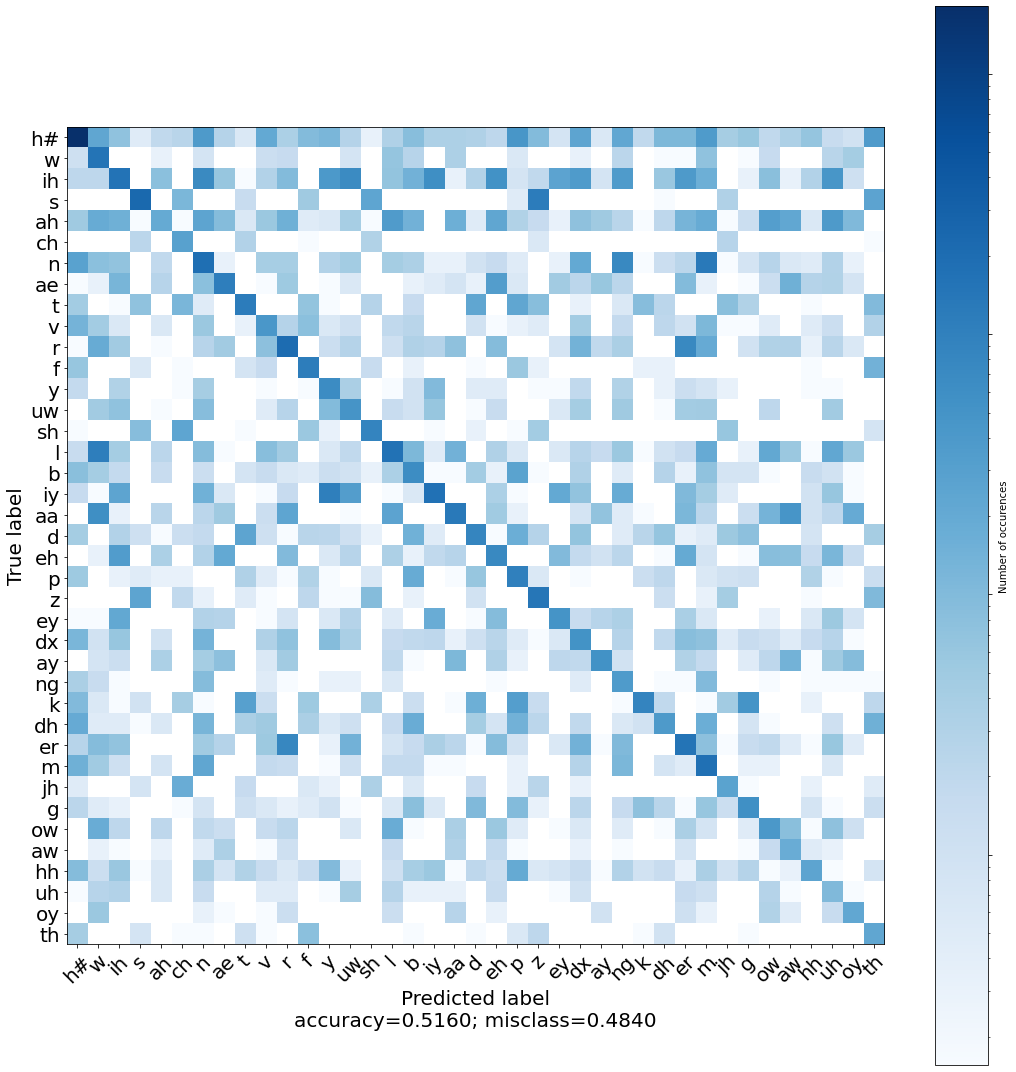

In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='',
                          cmap=None,
                          normalize=True,
                          font_size=20):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    from matplotlib import colors
    plt.rcParams['text.usetex'] = False

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    norm = colors.LogNorm()
    plt.figure(figsize=default_fig_size)
    plt.imshow(cm/np.sum(cm), interpolation='nearest', cmap=cmap, norm=norm)
    #plt.imshow(cm/np.max(cm), interpolation='nearest', cmap=cmap, norm=norm)
    plt.title(title)
    cbar = plt.colorbar(label = "Number of occurences")
    tick_labs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(tick_labs, fontsize=font_size)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize = font_size)
        plt.yticks(tick_marks, target_names, fontsize = font_size)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = font_size)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize = font_size)
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, target_names=phonemes, font_size=default_font_size)

In [8]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(labels_test, labels_pred, labels = phonemes)
mcm

array([[[49094,  1030],
        [ 2368, 11653]],

       [[61001,  1905],
        [  236,  1003]],

       [[58377,  1114],
        [ 3621,  1033]],

       [[61194,   312],
        [ 1184,  1455]],

       [[61580,   222],
        [ 2218,   125]],

       [[63397,   489],
        [   73,   186]],

       [[59272,  1761],
        [ 1944,  1168]],

       [[62303,   435],
        [  720,   687]],

       [[62122,   488],
        [  785,   750]],

       [[62928,   507],
        [  437,   273]],

       [[60432,  1188],
        [ 1209,  1316]],

       [[62833,   400],
        [  205,   707]],

       [[62253,  1258],
        [  211,   423]],

       [[62381,  1014],
        [  442,   308]],

       [[62967,   308],
        [  327,   543]],

       [[60637,   809],
        [ 1647,  1052]],

       [[62392,   867],
        [  483,   403]],

       [[60702,   733],
        [ 1616,  1094]],

       [[61393,   463],
        [ 1481,   808]],

       [[62389,   511],
        [  719,   526]],



# Extras

#### Z-Classification

In [9]:
clas2 = Classifier(1.5, .2, 1.5, .1) # Z optimal params

clas2.fit(features_train, labels_train, **{
    "n_mels":n_mels,
    "XorZ":"X",
    "N":20
})

print(f'Training Accuracy of z : {clas2.score(features_train, labels_train)}')
print(f'Test Accuracy of z     : {clas2.score(features_test, labels_test)}')

Number of samples: 7800
- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  61.261485722373855
normalizing
Target:  14.678188310367373
std 0.4754349982127149
- computing negative conceptors
Training Accuracy of z : 0.42705128205128207
Test Accuracy of z     : 0.4296515706602229


#### Bayesian Hyperparameter Tuning

In [10]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

X_train, X_test, y_train, y_test = train_test_split(features_train,
                                                    labels_train,
                                                    stratify = labels_train,
                                                    random_state = 1)

# Bayesian Optimization wrapper
def objective_function(W_in_scale,
                       b_scale,
                       spectral_radius,
                       weights):

    model = Classifier(W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights)
    model.fit(X_train, y_train, **const_params)
    return model.score(X_test, y_test)


parameters = {
    'W_in_scale': [.01, 2],
    'spectral_radius': [0.01, 4],
    'b_scale': [0, 2],
    'weights': [.01,1]
}

# Bayesian optimization of the objective function.
optimizer = BayesianOptimization(f = objective_function,
                                 pbounds = parameters,
                                 random_state = 0)
optimizer.maximize(init_points = 10, n_iter = 100)

best_params = optimizer.max['params']
print(f"Best parmaters: {best_params}; f(x) = {optimizer.max['target']}.")


# Scikitlearn
#opt = Classifier()
#opt = BayesSearchCV(Classifier(), parameters, n_iter=50, cv=3)
#opt.fit(features, labels, **{
#   "in_dim":n_mels,
#   "out_dim":n_mels
#})
#print(opt.score(fv, lv))
#print(opt.best_params_)

|   iter    |  target   | W_in_s... |  b_scale  | spectr... |  weights  |
-------------------------------------------------------------------------
Number of samples: 5850
- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  110.85803056174201
normalizing
Target:  99.92204005906343
std 8.072894980299349
- computing negative conceptors


KeyboardInterrupt: 

In [ ]:
#with open('res.txt','x') as file:
#    file.write(opt.score(fv,lv))
#    file.write(opt.best_params_)

#### Plotting Progress

In [ ]:
plt.rcParams['text.usetex'] = True
fig, ax1 = plt.subplots(figsize = (15, 5))

ax2 = ax1.twinx()

# Scores:
ax1.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, color='r', label="Accuracy - $f(\\rho$, $k_{W^in}$, $k_b$, $r$)")

# Parameters
W_in_scale = []
b_scale = []
spectral_radius = []
weights = []

for res in optimizer.res:
    W_in_scale.append(res["params"]["W_in_scale"])
    b_scale.append(res["params"]["b_scale"])
    spectral_radius.append(res["params"]["spectral_radius"])
    weights.append(res["params"]["weights"])

if True:
    ax1.plot(range(1, 1 + len(optimizer.space.target)), W_in_scale, "--", label="$W^{in}$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), b_scale, "--", label="$k_b$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), spectral_radius, "--", label="$r$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), weights, "--", label="$\\rho$")

ax1.set_xlabel('Iteration', fontsize = 20)
ax1.set_ylabel('Accuracy', color="r", fontsize = 20)
ax2.set_ylabel('Hyperparameter value', fontsize = 20)

ax1.legend(loc="upper left", fontsize = 20)
fig.show()